In [1]:
from bs4 import BeautifulSoup
import nltk
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# parse sample file
datapath =''
filename = 
soup = BeautifulSoup(open(datapath+ 'example_ttml.xml'), 'html.parser')
result = [(p['begin'], p['end'], p.text) for p in soup.find_all('p')]

In [10]:
soup

<?xml version="1.0" encoding="utf-8" ?>\n<tt ttp:profile="http://www.w3.org/TR/profile/sdp-us" xml:lang="en" xmlns="http://www.w3.org/ns/ttml" xmlns:ttm="http://www.w3.org/ns/ttml#metadata" xmlns:ttp="http://www.w3.org/ns/ttml#parameter" xmlns:tts="http://www.w3.org/ns/ttml#styling">\n<head>\n<styling>\n<style tts:displayalign="after" tts:extent="90% 90%" tts:origin="5% 5%" tts:textalign="center" xml:id="s1"></style>\n<style tts:backgroundcolor="black" tts:color="white" tts:fontsize=".72c" xml:id="s2"></style>\n<style tts:color="#E5E5E5" xml:id="s3"></style>\n<style tts:color="#CCCCCC" xml:id="s4"></style>\n</styling>\n<layout>\n<region style="s1" xml:id="r1"></region>\n</layout>\n</head>\n<body region="r1">\n<div>\n<p begin="00:00:00.620" end="00:00:04.049" style="s2">though<span style="s3"> many</span> have joined the stem</p>\n<p begin="00:00:02.639" end="00:00:05.910" style="s2">learning community and have brought many</p>\n<p begin="00:00:04.049" end="00:00:08.010" style="s2">impr

## Analysis of word frequency (only considering nouns)

In [3]:
#text block
raw= ' '.join([x[2] for x in result])

In [4]:
# tokenzie and position tagging using nltk library
# http://www.nltk.org/book/ch05.html
# to understand the meaning of tags: nltk.help.upenn_tagset()
text = nltk.word_tokenize(raw)
postags= nltk.pos_tag(text)

In [5]:
# turn the result into dataframe for the convenience of processing
df = pd.DataFrame(postags,columns =['word','type'])

In [6]:
#filter words by type, only keeping nouns
typepattern_prefix=['NN']
mask = df.type.str.slice(0,2).isin(typepattern_prefix)
filtered=df[mask]

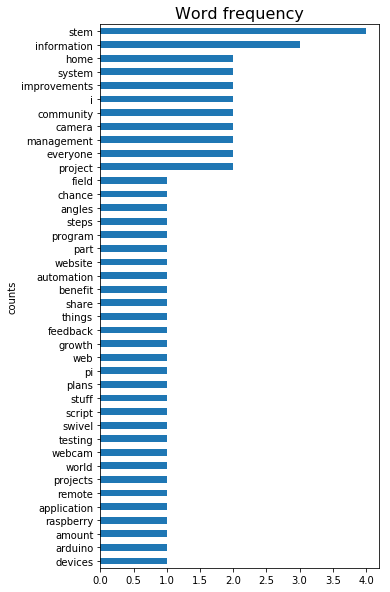

In [7]:
# plot word frequency
ax=filtered['word'].value_counts().sort_values(ascending=True).plot.barh(figsize=(5,10))
ax.set_ylabel('counts')
ax.set_title('Word frequency', fontsize=16)

## Analysis of speech speed on the video timeline

In [8]:
df2=pd.DataFrame(result, columns = ['sTimestamp','eTimestamp','words'])
df2['sTimestamp']=pd.to_datetime(df2['sTimestamp'])
df2['eTimestamp']=pd.to_datetime(df2['eTimestamp'])

In [9]:
from datetime import datetime, timedelta
df2['durSeconds']= (df2['eTimestamp']-df2['sTimestamp'])/ timedelta(seconds=1)

In [10]:
df2['wordcounts']=df2.apply(lambda row: len(row['words'].split(' ')),axis='columns')

In [11]:
df2.sample()

,sTimestamp,eTimestamp,words,durSeconds,wordcounts
5,2017-08-27 00:00:09.450,2017-08-27 00:00:12.150,large amount of growth in the field of,2.7,8


In [12]:
#fastest and slowest line by speech speed
df2['speechSpeed']=df2['wordcounts']/df2['durSeconds']

vStart=min(df2['sTimestamp'])
df2['offsetVideoStart'] = (df2['sTimestamp']-vStart)/timedelta(seconds=1)

print('--------slowest spoken line:----------------')
print(df2.sort_values(by=['speechSpeed']).iloc[0])
print('--------fastest spoken line:----------------')
print(df2.sort_values(by=['speechSpeed']).iloc[-1])

--------slowest spoken line:----------------
sTimestamp          2017-08-27 00:00:42.360000
eTimestamp          2017-08-27 00:00:45.989000
words                   information management
durSeconds                               3.629
wordcounts                                   2
speechSpeed                           0.551116
offsetVideoStart                         41.74
Name: 22, dtype: object
--------fastest spoken line:----------------
sTimestamp                        2017-08-27 00:00:44.070000
eTimestamp                        2017-08-27 00:00:47.250000
words               and I think that I could bring us a stem
durSeconds                                              3.18
wordcounts                                                10
speechSpeed                                          3.14465
offsetVideoStart                                       43.45
Name: 23, dtype: object


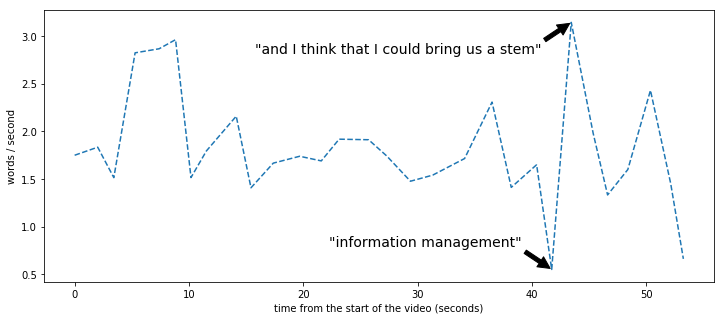

In [13]:
#fastest and slowest line by speech speed
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(111)
df2['speechSpeed']=df2['wordcounts']/df2['durSeconds']

ax.plot(df2['offsetVideoStart'],df2['speechSpeed'],'--')
ax.set_ylabel('words / second')
ax.set_xlabel('time from the start of the video (seconds)')

ax.annotate('\"and I think that I could bring us a stem\"',
            xy=(43.45, 3.14465), xycoords='data',
            xytext=(-30, -20), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top', size=14)

ax.annotate('\"information management\"',
            xy=(41.74, 0.551116), xycoords='data',
            xytext=(-30, 20), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom', size=14)